<a href="https://colab.research.google.com/github/johanjun/Google_Machine_Learning_Bootcamp_KR_2021/blob/main/kaggle/RSNA_MICCAI_BRAIN_TUMOR/rsna_miccai_brain_tumor_johanjun_1013_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install pydicom

     |████████████████████████████████| 2.0 MB 1.1 MB/s 


In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm
import random
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import cv2
import pickle

import matplotlib.pyplot as plt
import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [4]:
data_dir = '/content/drive/MyDrive/Google_Machine_Learning_Bootcamp_KR_2021/RSNA_MICCAI/data/rsna-miccai/'

In [5]:
train_df = pd.read_csv(data_dir + "train_labels.csv")
test_df = pd.read_csv(data_dir + "sample_submission.csv")

In this discussion a competition host has notified that there are some issues with these 3 cases
Patient IDs -

1. 00109 (FLAIR images are blank)
2. 00123 (T1w images are blank)
3. 00709 (FLAIR images are blank)
<br><br>Hence these can be excluded

In [6]:
#refer: https://www.kaggle.com/arnabs007/part-1-rsna-miccai-btrc-understanding-the-data
EXCLUDE = [109, 123, 709]
train_df = train_df[~train_df.BraTS21ID.isin(EXCLUDE)]

In [7]:
train_df.head()

,BraTS21ID,MGMT_value
0,0,1
1,2,1
2,3,0
3,5,1
4,6,1


In [8]:
cd /content/drive/MyDrive/Google_Machine_Learning_Bootcamp_KR_2021/RSNA_MICCAI/data/rsna-miccai/

/content/drive/MyDrive/Google_Machine_Learning_Bootcamp_KR_2021/RSNA_MICCAI/data/rsna-miccai


In [9]:
# train_df = pd.read_csv('train_df(over150).csv')

In [10]:
TYPES = ["FLAIR", "T1w", "T1wCE", "T2w"] #mpMRI scans

In [12]:
def get_all_image_paths(BraTS21ID, image_type, folder="train"): #get an array of all the images of a particular type or a particular patient id
    assert(image_type in TYPES) #only in types
    patient_path = os.path.join(data_dir + "%s/" % folder, str(BraTS21ID).zfill(5)) #다른 폴더일 수도 있음
    #print(lambda x: int(x[:-4].split("-")[-1]))
    
    paths = sorted(glob.glob(os.path.join(patient_path, image_type, "*")), key=lambda x: int(x[:-4].split("-")[-1])) #sort
    #print(paths)
    
    num_images = len(paths)
    
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)
    if num_images < 10:
        jump = 1
    else:
        jump = 3
        
    return np.array(paths[start:end:jump])

In [13]:
def get_all_images(BraTS21ID, image_type, folder="train", size=225):
    return [load_dicom(path, size) for path in get_all_image_paths(BraTS21ID, image_type, folder)]

In [14]:
def get_all_data_train(image_type):
    global train_df
    
    X = []
    y = []
    train_ids = []

    for i in tqdm(train_df.index):
        tmp_x = train_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "train", IMAGE_SIZE)
        label = tmp_x["MGMT_value"]

        X += images
        y += [label] * len(images)
        train_ids += [int(tmp_x["BraTS21ID"])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

def get_all_data_test(image_type):
    global test_df
    
    X = []
    test_ids = []

    for i in tqdm(test_df.index):
        tmp_x = test_df.loc[i]
        images = get_all_images(int(tmp_x["BraTS21ID"]), image_type, "test", IMAGE_SIZE)
        X += images
        test_ids += [int(tmp_x["BraTS21ID"])] * len(images)

    return np.array(X), np.array(test_ids)

In [15]:
IMAGE_SIZE = 64

In [16]:
# pickling
with open(data_dir+'X_T1wCE.pkl', 'rb') as f:
  X_T1wCE = pickle.load(f)

with open(data_dir+'y_T1wCE.pkl', 'rb') as f:
  y_T1wCE = pickle.load(f)

with open(data_dir+'train_idt_T1wCE.pkl', 'rb') as f:
  train_idt_T1wCE = pickle.load(f)

with open(data_dir+'X_test_T1wCE.pkl', 'rb') as f:
  X_test_T1wCE = pickle.load(f)

with open(data_dir+'test_idt_T1wCE.pkl', 'rb') as f:
  test_idt_T1wCE = pickle.load(f)
#pickling
with open(data_dir+'X_FLAIR.pkl', 'rb') as f:
  X_FLAIR = pickle.load(f)

with open(data_dir+'y_FLAIR.pkl', 'rb') as f:
  y_FLAIR = pickle.load(f)

with open(data_dir+'train_idt_FLAIR.pkl', 'rb') as f:
  train_idt_FLAIR = pickle.load(f)

with open(data_dir+'X_test_FLAIR.pkl', 'rb') as f:
  X_test_FLAIR = pickle.load(f)

with open(data_dir+'test_idt_FLAIR.pkl', 'rb') as f:
  test_idt_FLAIR = pickle.load(f)
#pickling
with open(data_dir+'X_T2w.pkl', 'rb') as f:
  X_T2w = pickle.load(f)

with open(data_dir+'y_T2w.pkl', 'rb') as f:
  y_T2w = pickle.load(f)

with open(data_dir+'train_idt_T2w.pkl', 'rb') as f:
  train_idt_T2w = pickle.load(f)

with open(data_dir+'X_test_T2w.pkl', 'rb') as f:
  X_test_T2w = pickle.load(f)

with open(data_dir+'test_idt_T2w.pkl', 'rb') as f:
  test_idt_T2w = pickle.load(f)
#pickling
with open(data_dir+'X_T1w.pkl', 'rb') as f:
  X_T1w = pickle.load(f)

with open(data_dir+'y_T1w.pkl', 'rb') as f:
  y_T1w = pickle.load(f)

with open(data_dir+'train_idt_T1w.pkl', 'rb') as f:
  train_idt_T1w = pickle.load(f)

with open(data_dir+'X_test_T1w.pkl', 'rb') as f:
  X_test_T1w = pickle.load(f)

with open(data_dir+'test_idt_T1w.pkl', 'rb') as f:
  test_idt_T1w = pickle.load(f)

In [17]:
X_test = np.concatenate([X_test_FLAIR, X_test_T1w, X_test_T1wCE, X_test_T2w], axis=0)
test_idt = np.concatenate([test_idt_FLAIR, test_idt_T1w, test_idt_T1wCE, test_idt_T2w], axis=0)

In [28]:
X_train, X_valid, y_train, y_valid, train_idt_train, train_idt_valid = train_test_split(X_T1wCE, y_T1wCE, train_idt_T1wCE, test_size=0.05)

In [29]:
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [30]:
X_train_exp = tf.expand_dims(X_train, -1)
augmented_image = data_augmentation(X_train_exp)
X_train_sq = tf.squeeze(augmented_image)

X_train = np.concatenate([X_train, X_train_sq], axis=0)
y_train = np.concatenate([y_train, y_train], axis=0)

train_idt_train = np.concatenate([train_idt_train, train_idt_train], axis=0)

In [31]:
X_train = tf.expand_dims(X_train, axis=-1) #expand the dimension at the end of the array
X_valid = tf.expand_dims(X_valid, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

y_train = to_categorical(y_train) #one-hot incoding
y_valid = to_categorical(y_valid)

In [34]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, train_idt_train.shape, train_idt_valid.shape


(TensorShape([30772, 64, 64, 1]),
 (30772, 2),
 TensorShape([810, 64, 64, 1]),
 (810, 2),
 (30772,),
 (810,))

In [35]:
X2 = np.concatenate([X_FLAIR, X_T2w, X_T1w, X_T1wCE], axis=0)
y2 = np.concatenate([y_FLAIR, y_T2w, y_T1w, y_T1wCE], axis=0)
train_idt2 = np.concatenate([train_idt_FLAIR, train_idt_T2w, train_idt_T1w, train_idt_T1wCE], axis=0)

In [36]:
X_train2, X_valid2, y_train2, y_valid2, train_idt_train2, train_idt_valid2 = train_test_split(X2, y2, train_idt2, test_size=0.05)

In [37]:
X_train2 = np.expand_dims(X_train2, axis=-1) 
X_valid2 = np.expand_dims(X_valid2, axis=-1)

y_train2 = to_categorical(y_train2) 
y_valid2 = to_categorical(y_valid2)

In [39]:
def create_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', padding='VALID', 
                                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 1)))
    model.add(keras.layers.BatchNormalization())
    
    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPool2D(pool_size=(2,2)))

    model.add(keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='VALID'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.Conv2D(filters=128, kernel_size=3, activation='relu', padding='SAME'))
    model.add(keras.layers.BatchNormalization())

    model.add(keras.layers.MaxPool2D(pool_size=(2,2)))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
    model.add(keras.layers.Dense(2, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)))
    return model

In [40]:
## Hyper Parameters
IMAGE_SIZE = 64
N_EPOCHS = 50
N_BATCH = 32
N_TRAIN = X_train.shape[0]
N_VAL = X_valid.shape[0]

learning_rate = 0.0001
steps_per_epoch = N_TRAIN / N_BATCH
validation_steps = int(np.ceil(N_VAL / N_BATCH))

In [41]:
## Create model, compile & summary
model = create_model()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate),
              loss='categorical_crossentropy', #label이 ohe이 아니면 sparse를 쓰면 자동으로 ohe
              metrics=[tf.keras.metrics.AUC()])

In [42]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid2, y_valid2),
)

Epoch 1/50
961/961 [==============================] - 32s 14ms/step - loss: 2.0587 - auc: 0.5863 - val_loss: 1.3404 - val_auc: 0.6221
Epoch 2/50
961/961 [==============================] - 13s 14ms/step - loss: 1.0136 - auc: 0.6402 - val_loss: 0.9073 - val_auc: 0.6451
Epoch 3/50
961/961 [==============================] - 13s 14ms/step - loss: 0.8026 - auc: 0.7139 - val_loss: 0.8698 - val_auc: 0.7023
Epoch 4/50
961/961 [==============================] - 13s 14ms/step - loss: 0.7308 - auc: 0.7964 - val_loss: 0.9041 - val_auc: 0.7230
Epoch 5/50
961/961 [==============================] - 13s 14ms/step - loss: 0.6501 - auc: 0.8735 - val_loss: 0.8577 - val_auc: 0.7568
Epoch 6/50
961/961 [==============================] - 13s 14ms/step - loss: 0.5749 - auc: 0.9242 - val_loss: 0.9478 - val_auc: 0.7435
Epoch 7/50
961/961 [==============================] - 13s 14ms/step - loss: 0.5078 - auc: 0.9557 - val_loss: 0.9901 - val_auc: 0.7442
Epoch 8/50
961/961 [==============================] - 13s 14ms

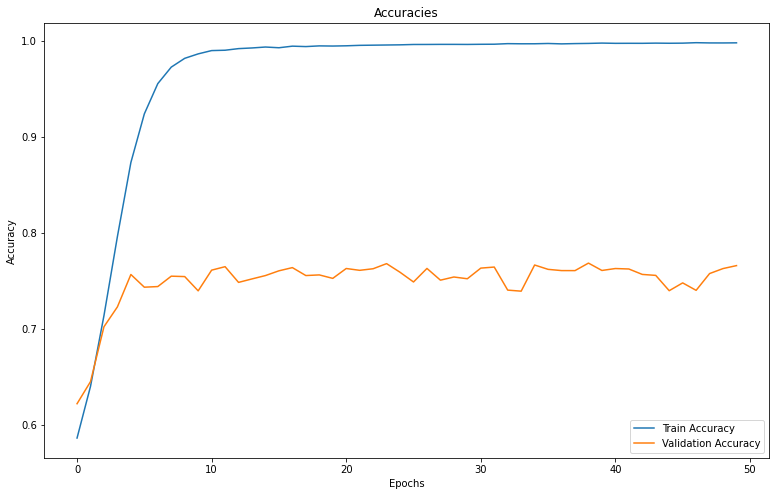

In [43]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc"], label = "Train Accuracy")
plt.plot(history.history["val_auc"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

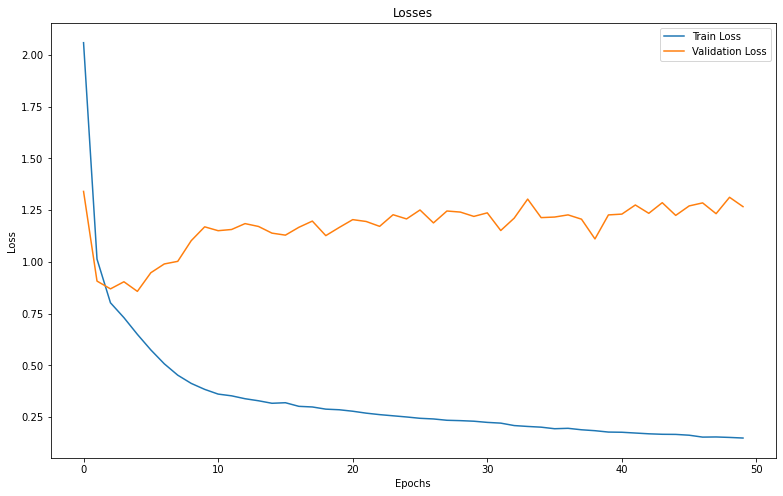

In [44]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_valid) #pedict on X_valid
pred = np.argmax(y_pred, axis = 1) #index of largest value by column 열 기준 가장 큰 값의 인덱스

result = pd.DataFrame(train_idt_valid) #BraTS21ID
result[1] = pred #MGMT_value
result.columns=["BraTS21ID","MGMT_value"]
#Group by BraTS21ID and average + do not use index
result_final = result.groupby("BraTS21ID", as_index = False).mean()
result_final = result_final.merge(train_df, on = "BraTS21ID") #merge train_df
from sklearn.metrics import roc_auc_score
roc_auc_score(result_final.MGMT_value_y, result_final.MGMT_value_x,)

In [ ]:

#pickling
with open(data_dir+'X_T1wCE.pkl', 'rb') as f:
  X_T1wCE = pickle.load(f)

with open(data_dir+'y_T1wCE.pkl', 'rb') as f:
  y_T1wCE = pickle.load(f)

with open(data_dir+'train_idt_T1wCE.pkl', 'rb') as f:
  train_idt_T1wCE = pickle.load(f)

with open(data_dir+'X_test_T1wCE.pkl', 'rb') as f:
  X_test_T1wCE = pickle.load(f)

with open(data_dir+'test_idt_T1wCE.pkl', 'rb') as f:
  test_idt_T1wCE = pickle.load(f)
#pickling
with open(data_dir+'X_FLAIR.pkl', 'rb') as f:
  X_FLAIR = pickle.load(f)

with open(data_dir+'y_FLAIR.pkl', 'rb') as f:
  y_FLAIR = pickle.load(f)

with open(data_dir+'train_idt_FLAIR.pkl', 'rb') as f:
  train_idt_FLAIR = pickle.load(f)

with open(data_dir+'X_test_FLAIR.pkl', 'rb') as f:
  X_test_FLAIR = pickle.load(f)

with open(data_dir+'test_idt_FLAIR.pkl', 'rb') as f:
  test_idt_FLAIR = pickle.load(f)
#pickling
with open(data_dir+'X_T2w.pkl', 'rb') as f:
  X_T2w = pickle.load(f)

with open(data_dir+'y_T2w.pkl', 'rb') as f:
  y_T2w = pickle.load(f)

with open(data_dir+'train_idt_T2w.pkl', 'rb') as f:
  train_idt_T2w = pickle.load(f)

with open(data_dir+'X_test_T2w.pkl', 'rb') as f:
  X_test_T2w = pickle.load(f)

with open(data_dir+'test_idt_T2w.pkl', 'rb') as f:
  test_idt_T2w = pickle.load(f)
#pickling
with open(data_dir+'X_T1w.pkl', 'rb') as f:
  X_T1w = pickle.load(f)

with open(data_dir+'y_T1w.pkl', 'rb') as f:
  y_T1w = pickle.load(f)

with open(data_dir+'train_idt_T1w.pkl', 'rb') as f:
  train_idt_T1w = pickle.load(f)

with open(data_dir+'X_test_T1w.pkl', 'rb') as f:
  X_test_T1w = pickle.load(f)

with open(data_dir+'test_idt_T1w.pkl', 'rb') as f:
  test_idt_T1w = pickle.load(f)

In [ ]:
X2 = np.concatenate([X_FLAIR, X_T2w, X_T1w, X_T1wCE], axis=0)
y2 = np.concatenate([y_FLAIR, y_T2w, y_T1w, y_T1wCE], axis=0)
train_idt2 = np.concatenate([train_idt_FLAIR, train_idt_T2w, train_idt_T1w, train_idt_T1wCE], axis=0)

In [ ]:
X_train2, X_valid2, y_train2, y_valid2, train_idt_train2, train_idt_valid2 = train_test_split(X2, y2, train_idt2, test_size=0.2)

In [ ]:
X_train2 = tf.expand_dims(X_train2, axis=-1) #expand the dimension at the end of the array
X_valid2 = tf.expand_dims(X_valid2, axis=-1)

y_train2 = to_categorical(y_train2) #one-hot incoding
y_valid2 = to_categorical(y_valid2)

In [ ]:
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=N_EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=(X_valid2, y_valid2),
)

Epoch 1/60
301/301 [==============================] - 7s 25ms/step - loss: 0.0669 - auc: 0.9999 - val_loss: 1.4234 - val_auc: 0.6921
Epoch 2/60
301/301 [==============================] - 7s 22ms/step - loss: 0.0726 - auc: 0.9998 - val_loss: 1.4681 - val_auc: 0.7043
Epoch 3/60
301/301 [==============================] - 7s 22ms/step - loss: 0.0707 - auc: 0.9998 - val_loss: 1.3609 - val_auc: 0.6965
Epoch 4/60
301/301 [==============================] - 7s 22ms/step - loss: 0.0721 - auc: 0.9999 - val_loss: 1.4840 - val_auc: 0.6927
Epoch 5/60
301/301 [==============================] - 7s 22ms/step - loss: 0.0673 - auc: 0.9999 - val_loss: 1.4969 - val_auc: 0.6907
Epoch 6/60
301/301 [==============================] - 7s 22ms/step - loss: 0.0644 - auc: 0.9999 - val_loss: 1.4808 - val_auc: 0.6985
Epoch 7/60
301/301 [==============================] - 7s 22ms/step - loss: 0.0597 - auc: 1.0000 - val_loss: 1.4993 - val_auc: 0.6974
Epoch 8/60
301/301 [==============================] - 7s 22ms/step - 

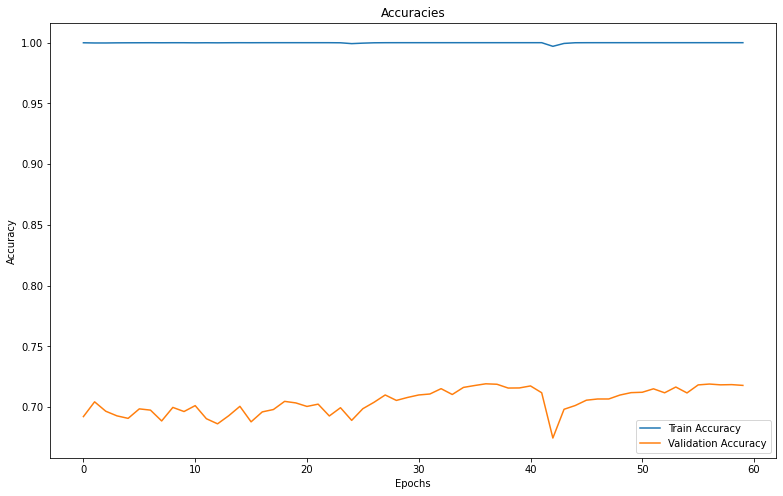

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["auc"], label = "Train Accuracy")
plt.plot(history.history["val_auc"],label = "Validation Accuracy")
plt.title("Accuracies")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

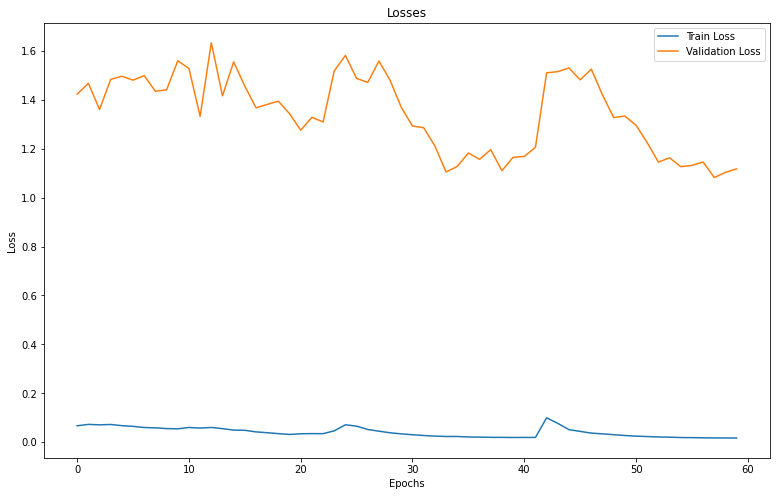

In [ ]:
plt.figure(figsize = (13,8))
plt.plot(history.history["loss"], label = "Train Loss")
plt.plot(history.history["val_loss"],label = "Validation Loss")
plt.title("Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(X_valid) #pedict on X_valid
pred = np.argmax(y_pred, axis = 1) #index of largest value by column 열 기준 가장 큰 값의 인덱스

result = pd.DataFrame(train_idt_valid) #BraTS21ID
result[1] = pred #MGMT_value
result.columns=["BraTS21ID","MGMT_value"]
#Group by BraTS21ID and average + do not use index
result_final = result.groupby("BraTS21ID", as_index = False).mean()
result_final = result_final.merge(train_df, on = "BraTS21ID") #merge train_df
from sklearn.metrics import roc_auc_score
roc_auc_score(result_final.MGMT_value_y, result_final.MGMT_value_x,)

0.8631860839890036